In [ ]:
#Code designed for medical image analysis using deep learning 
#Actor: Eduardo Pereira

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import glob
from keras import backend as K

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
#Range of Images
range= 3500 #1500

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 100 #25
BS = 8
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = ['/content/drive/MyDrive/Projeto/Imagens/Normal', 
          '/content/drive/MyDrive/Projeto/Imagens/COVID-19']
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    #print(imagePath)
    images_list = glob.glob(imagePath + '/*.png')
    #set range of images
    images_listFiltered= []
    for indexImage,pathImage in enumerate(images_list):
            images_listFiltered.append(pathImage) if indexImage <= range else None
    for index_image,image_path in enumerate(images_listFiltered):
    # extract the class label from the filename 
        label = 0 if 'Normal' in imagePath else 1

    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
        print(image_path," - ",len(images_listFiltered)," | ",index_image)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.resize(image, (224, 224))
        image = cv2.resize(image, (128, 128))

    # update the data and labels lists, respectively
        data.append(image)
        labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)
#print(data,labels)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
#print(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

# initialize the training data augmentation object
''' trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest") '''

# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(128, 128, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy",f1_m,precision_m, recall_m])

# train the head of the network
print("[INFO] training head...")

H= model.fit(trainX, trainY, batch_size = BS, epochs = EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
''' print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_)) '''

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
model.save('/content/drive/MyDrive/Projeto/covid_detector_4500', save_format="h5")

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Projeto/Imagens/Normal/Normal (6432)_GRAY.png  -  3501  |  2214
/content/drive/MyDrive/Projeto/Imagens/Normal/Normal (11645)_GRAY.png  -  3501  |  2215
/content/drive/MyDrive/Projeto/Imagens/Normal/Normal (6485)_GRAY.png  -  3501  |  2216
/content/drive/MyDrive/Projeto/Imagens/Normal/Normal (5878)_GRAY.png  -  3501  |  2217
/content/drive/MyDrive/Projeto/Imagens/Normal/Normal (10948)_GRAY.png  -  3501  |  2218
/content/drive/MyDrive/Projeto/Imagens/Normal/Normal (3482)_GRAY.png  -  3501  |  2219
/content/drive/MyDrive/Projeto/Imagens/Normal/Normal (10606)_GRAY.png  -  3501  |  2220
/content/drive/MyDrive/Projeto/Imagens/Normal/Normal (10489)_GRAY.png  -  3501  |  2221
/content/drive/MyDrive/Projeto/Imagens/Normal/Normal (4004)_GRAY.png  -  3501  |  2222
/content/drive/MyDrive/Projeto/Imagens/Normal/Normal (11449)_GRAY.png  -  3501  |  2223
/content/drive/MyDrive/Projeto/Imagens/Normal/Normal (3926)_GRAY.png  -  3

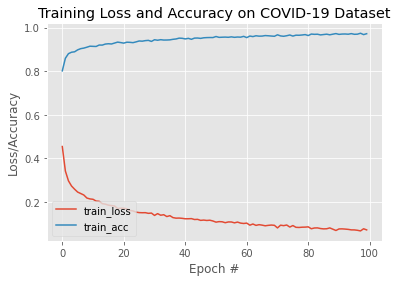

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
#plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plot.png')

#Test Model with Prediction

In [ ]:
#Import image
image = cv2.imread("/content/covid_19_GRAY.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))

#Normalazing image array
input_data = np.array([image]) / 255.0
#print(input_data)
#make prediction
#model.predict(input_data)
model.predict(input_data)

In [ ]:
import keras
#Import image
image = cv2.imread("/content/covid_19_GRAY.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (128, 128))

#Normalazing image array
input_data = np.array([image]) / 255.0
#print(input_data)

#load model
model= keras.models.load_model('/content/drive/MyDrive/Projeto/covid_detector_v4', custom_objects={"precision_m": precision_m,"recall_m":recall_m,"f1_m":f1_m})

#make prediction
#model.predict(input_data)
#model.predict(input_data)
model.predict(image)